In [1]:
# import necessar libraries
import pandas as pd
import numpy as np

import data_preparation as dp
import visualizations as viz

# read data
data = pd.read_csv("../data/training_set_features.csv", index_col = 0)
vac = pd.read_csv("../data/training_set_labels.csv", index_col = 0)

all_data = data.merge(vac['h1n1_vaccine'], left_index=True, right_index=True)

all_data.drop(['doctor_recc_seasonal',
               'opinion_seas_vacc_effective',
               'opinion_seas_risk',
               'opinion_seas_sick_from_vacc'], 
              axis = 1,
              inplace=True)

X = dp.missing(all_data)
y = X.pop('h1n1_vaccine')

for c in X.columns:
    X = dp.dummy(X, c)

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

CV score:     84.84%
X-test score: 85.28%
RMSE:         0.3837

Train score
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15770
           1       1.00      1.00      1.00      4260

    accuracy                           1.00     20030
   macro avg       1.00      1.00      1.00     20030
weighted avg       1.00      1.00      1.00     20030



X-test score

              precision    recall  f1-score   support

           0       0.86      0.96      0.91      5263
           1       0.77      0.44      0.56      1414

    accuracy                           0.85      6677
   macro avg       0.82      0.70      0.73      6677
weighted avg       0.84      0.85      0.84      6677



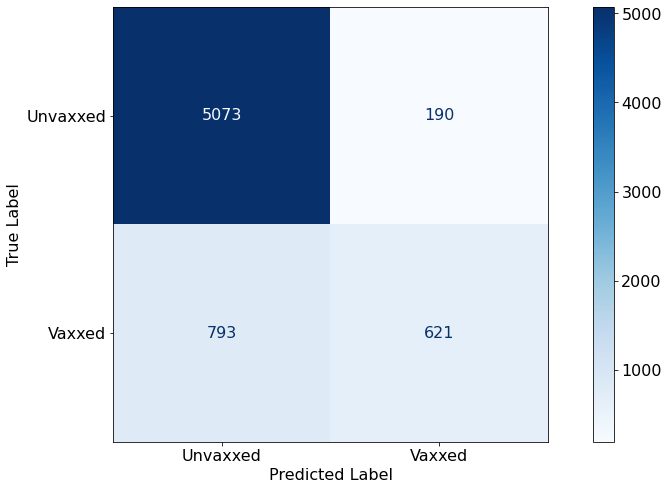

In [3]:
# the baseline model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=1)
dp.scores(X_train, y_train, X_test, y_test, rfc)
viz.plot_cm(X_train, y_train, X_test, y_test, rfc)

**Feature engineering part 1**

In [4]:
# use SMOTE to balance the ratio of target
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=1)
X_train_rs, y_train_rs = sm.fit_resample(X_train, y_train)

In [10]:
y_train.value_counts()

0    15770
1     4260
Name: h1n1_vaccine, dtype: int64

In [5]:
y_train_rs.value_counts()

1    15770
0    15770
Name: h1n1_vaccine, dtype: int64

In [6]:
# use pipeline for the readability
from imblearn.pipeline import Pipeline
pipe = Pipeline(steps=[('sm', SMOTE(random_state=1)),
                       ('rfc', RandomForestClassifier(random_state=1))])

The scores using SMOTE were not improved.

CV score:     84.64%
X-test score: 85.13%
RMSE:         38.56%

Train score
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15770
           1       1.00      1.00      1.00      4260

    accuracy                           1.00     20030
   macro avg       1.00      1.00      1.00     20030
weighted avg       1.00      1.00      1.00     20030



X-test score

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      5263
           1       0.72      0.48      0.58      1414

    accuracy                           0.85      6677
   macro avg       0.80      0.72      0.74      6677
weighted avg       0.84      0.85      0.84      6677



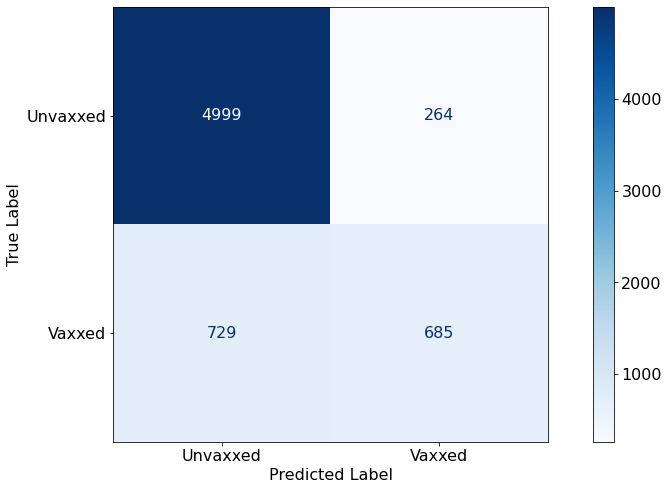

In [7]:
dp.scores(X_train, y_train, X_test, y_test, pipe)
viz.plot_cm(X_train, y_train, X_test, y_test, pipe)

Hyperparameter steps are done using gridsearchcv.

In [4]:
from sklearn.model_selection import GridSearchCV

Tried to improve scores by using SMOTE, but the best parameter was the default value for k_neighbors.

In [11]:
param = {'sm__k_neighbors': [3, 5, 7, 9, 11]}
gs = GridSearchCV(estimator=pipe,
                  param_grid=param,
                  cv=5)

gs.fit(X_train, y_train)
gs.best_params_

{'sm__k_neighbors': 5}

**Hyperparameter Tuning Part 1**

In [9]:
rfc = RandomForestClassifier(random_state=1)

param = {'criterion': ['gini', 'entropy'],
         'min_samples_leaf': [1, 2],
         'min_samples_split': [3, 4, 5],
         'max_depth': [12, 13, 14, 15, 16],
         'max_features': ['auto', 'log2', None]
        }
gs = GridSearchCV(estimator=rfc,
                  param_grid=param,
                  cv=5)

gs.fit(X_train, y_train)
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 15,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4}

**Hyperparameter Tuning Part 2**

Below step is separated to save time.

In [16]:
rfc_3 = RandomForestClassifier(random_state=1,
                                 criterion = 'entropy',
                                 max_features = 'auto',
                                 max_depth = 15,
                                 min_samples_leaf = 1,
                                 min_samples_split=4
                                )

param = {'n_estimators': [i for i in range(970, 990)]}
gs = GridSearchCV(estimator=rfc_3,
                  param_grid=param,
                  cv=5)

gs.fit(X_train, y_train)
gs.best_params_

{'n_estimators': 982}

**The final model**

This has the highest recall value for 0's (not vaccinated). The below confusion matrix shows the most number of predicted "not vaccinated".

CV score:     85.02%
X-test score: 85.20%
RMSE:         0.3847

Train score
              precision    recall  f1-score   support

           0       0.91      0.99      0.95     15770
           1       0.94      0.63      0.75      4260

    accuracy                           0.91     20030
   macro avg       0.93      0.81      0.85     20030
weighted avg       0.92      0.91      0.91     20030



X-test score

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      5263
           1       0.78      0.42      0.55      1414

    accuracy                           0.85      6677
   macro avg       0.82      0.69      0.73      6677
weighted avg       0.84      0.85      0.83      6677



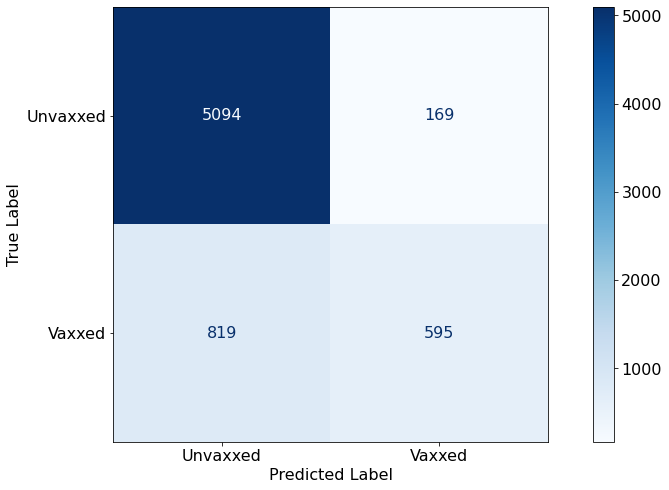

In [17]:
rfc_hpt = RandomForestClassifier(random_state=1,
                                 criterion = 'entropy',
                                 max_features = 'auto',
                                 max_depth = 15,
                                 min_samples_leaf = 1,
                                 min_samples_split=4,
                                 n_estimators = 982
                                )

dp.scores(X_train, y_train, X_test, y_test, rfc_hpt)
viz.plot_cm(X_train, y_train, X_test, y_test, rfc_hpt)

Steps to show the most important features

In [18]:
import matplotlib.pyplot as plt

In [19]:
feat_impt = pd.concat([pd.DataFrame(rfc_hpt.feature_importances_, columns = ['FI_score']),
                       pd.DataFrame(X_train.columns.values, columns = ['Features'])],
                      axis = 1)

In [20]:
feat_impt.sort_values(by = 'FI_score', inplace=True)

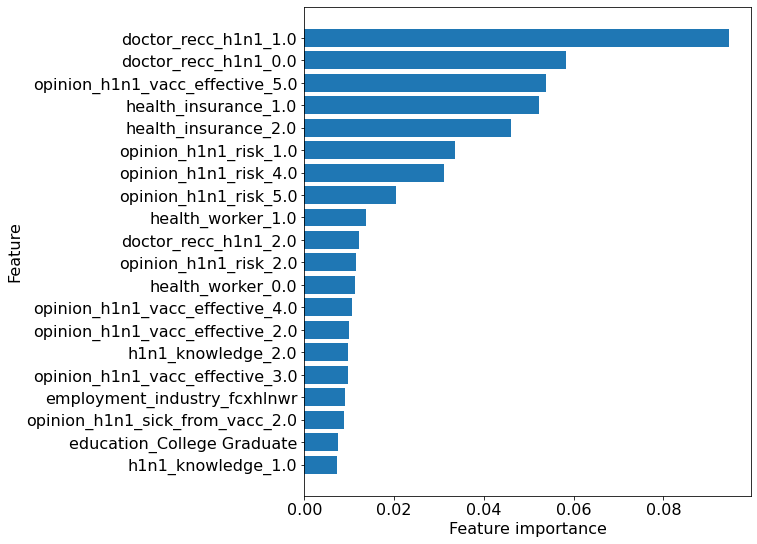

In [21]:
plt.figure(figsize=(8,9))
plt.barh(range(20), feat_impt.FI_score[-20:], align='center') 
plt.yticks(np.arange(20), feat_impt.Features[-20:]) 
plt.xlabel('Feature importance')
plt.ylabel('Feature');

**Feature engineering part 2**

Another baseline model was created using features/predictors with the high importance scores. The below steps were done to check if better scores can be calculated.

In [8]:
feat_impt.Features.loc[feat_impt.FI_score > 0.01]

48    opinion_h1n1_vacc_effective_4.0
7                  h1n1_knowledge_2.0
51              opinion_h1n1_risk_2.0
40                  health_worker_1.0
54              opinion_h1n1_risk_5.0
50              opinion_h1n1_risk_1.0
53              opinion_h1n1_risk_4.0
44               health_insurance_2.0
43               health_insurance_1.0
49    opinion_h1n1_vacc_effective_5.0
30               doctor_recc_h1n1_0.0
31               doctor_recc_h1n1_1.0
Name: Features, dtype: object

In [9]:
col = [c for c in feat_impt.Features.loc[feat_impt.FI_score > 0.01]]

In [10]:
X_train_col = X_train[col]
X_test_col = X_test[col]

Scores from the new baseline model were not improved.

CV score:     84.61%
X-test score: 84.51%
RMSE:         39.35%
RMSE:         0.3935

Train score
              precision    recall  f1-score   support

           0       0.88      0.95      0.91     15770
           1       0.72      0.50      0.59      4260

    accuracy                           0.85     20030
   macro avg       0.80      0.72      0.75     20030
weighted avg       0.84      0.85      0.84     20030



X-test score

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      5263
           1       0.69      0.49      0.57      1414

    accuracy                           0.85      6677
   macro avg       0.78      0.72      0.74      6677
weighted avg       0.83      0.85      0.84      6677



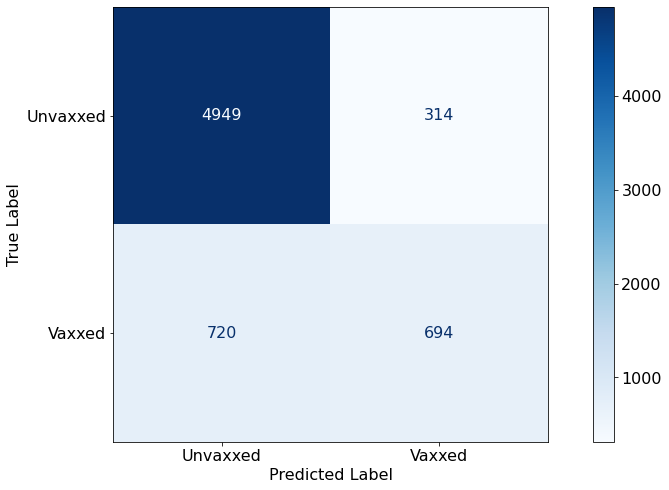

In [11]:
dp.scores(X_train_col, y_train, X_test_col, y_test, rfc)
viz.plot_cm(X_train_col, y_train, X_test_col, y_test, rfc)

Hyperparameter tuning on the new baseline model

In [25]:
param = {'max_depth': [i for i in range(5, 15)],
         'min_samples_leaf': [1, 2, 3, 4, 5],
         'min_samples_split': [i for i in range(2, 5)],
         'criterion': ['gini', 'entropy'],
         'max_features': ['auto', 'log2', None]
        }
gs = GridSearchCV(estimator=rfc,
                  param_grid=param,
                  cv=5)

gs.fit(X_train_col, y_train)
gs.best_params_

{'criterion': 'gini',
 'max_depth': 6,
 'max_features': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

The scores are not improved compared to the final model.

CV score:     84.75%
X-test score: 84.42%
RMSE:         39.47%
RMSE:         0.3947

Train score
              precision    recall  f1-score   support

           0       0.87      0.94      0.91     15770
           1       0.70      0.49      0.58      4260

    accuracy                           0.85     20030
   macro avg       0.79      0.72      0.74     20030
weighted avg       0.84      0.85      0.84     20030



X-test score

              precision    recall  f1-score   support

           0       0.87      0.94      0.91      5263
           1       0.69      0.48      0.57      1414

    accuracy                           0.84      6677
   macro avg       0.78      0.71      0.74      6677
weighted avg       0.83      0.84      0.83      6677



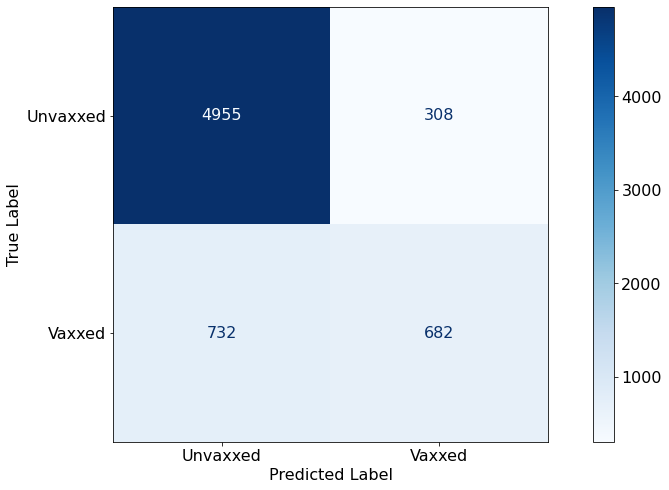

In [26]:
rfc_hpt_2 = RandomForestClassifier(random_state=1,
                                   max_depth = 6,
                                   min_samples_leaf = 1,
                                   min_samples_split=2,
                                   n_estimators = 200,
                                   max_features = None
                                  )

dp.scores(X_train_col, y_train, X_test_col, y_test, rfc_hpt_2)
viz.plot_cm(X_train_col, y_train, X_test_col, y_test, rfc_hpt_2)